<a href="https://colab.research.google.com/github/Akash2021/Covid19ArticleSummarizationClustering/blob/main/JupyterNotebooks/RoBERTa_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Installation
!pip install datasets==1.0.2
!pip install transformers
!pip install rouge_score

     |████████████████████████████████| 1.8MB 9.4MB/s 
     |████████████████████████████████| 245kB 51.0MB/s 
     |████████████████████████████████| 2.5MB 8.0MB/s 
     |████████████████████████████████| 3.3MB 44.9MB/s 
     |████████████████████████████████| 901kB 46.7MB/s 


In [ ]:
import datasets
import transformers
import pandas as pd
from datasets import Dataset

#Tokenizer
from transformers import RobertaTokenizerFast

#Encoder-Decoder Model
from transformers import EncoderDecoderModel

#Training

from transformers import Seq2SeqTrainer
# from  transformers import seq2seq_training_args
from transformers import TrainingArguments
from dataclasses import dataclass, field
from typing import Optional

In [ ]:
!pip install langdetect

     |████████████████████████████████| 983kB 7.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993242 sha256=5db24f1e635e495e07a2809fdddde88a3d089bf885777846fdb81543113653e2
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7ddc6c92d3aa015cf1a498df5a70268996
Successfully built langdetect


In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/metadata.csv",low_memory=False)

In [ ]:
df=df[:80000]

In [ ]:
df[:1]

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN


In [ ]:

df=df[['title','abstract']]

In [ ]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54957 entries, 0 to 79999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     54957 non-null  object
 1   abstract  54957 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [9]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['abstract'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 54957/54957 [04:55<00:00, 185.94it/s]



In [10]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 54957

{'af': 2,
 'ca': 8,
 'cy': 1,
 'de': 687,
 'en': 53876,
 'es': 13,
 'fi': 2,
 'fr': 18,
 'hr': 1,
 'hu': 10,
 'it': 65,
 'ko': 2,
 'nl': 209,
 'pt': 3,
 'ro': 6,
 'unknown': 7,
 'vi': 1,
 'zh-cn': 46}
Total: 54957

{'af': 2,
 'ca': 8,
 'cy': 1,
 'de': 687,
 'en': 53876,
 'es': 13,
 'fi': 2,
 'fr': 18,
 'hr': 1,
 'hu': 10,
 'it': 65,
 'ko': 2,
 'nl': 209,
 'pt': 3,
 'ro': 6,
 'unknown': 7,
 'vi': 1,
 'zh-cn': 46}


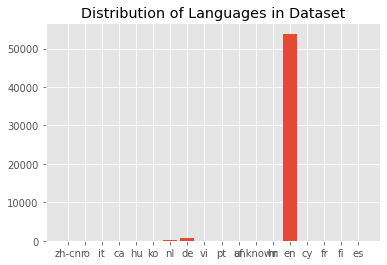

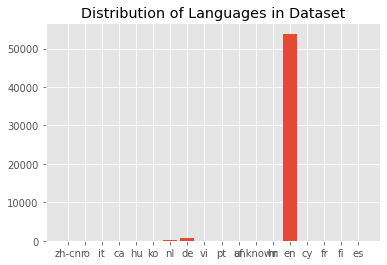

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [ ]:
df=df.rename(columns={"title":"Summary","abstract":"Text"})
df.info()

In [ ]:
print(len(df))
df.head()

In [14]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz   

     |                                | 92kB 2.8MB/s eta 0:02:57Collecting https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
     |████████████████████████████████| 500.6MB 34kB/s 
     |████████████████████████████████| 500.6MB 34kB/s 
  Created wheel for en-core-sci-lg: filename=en_core_sci_lg-0.2.4-cp37-none-any.whl size=501343162 sha256=67a4cfc383c83bd8d4a4872012b2d2287845e90876d9c341c8228d48b958043d
  Stored in directory: /root/.cache/pip/wheels/ea/ab/e5/fa667519032799529ce6a50944a82d6ae3603819cd07836aa2
  Created wheel for en-core-sci-lg: filename=en_core_sci_lg-0.2.4-cp37-none-any.whl size=501343162 sha256=67a4cfc383c83bd8d4a4872012b2d2287845e90876d9c341c8228d48b958043d
  Stored in directory: /root/.cache/pip/wheels/ea/ab/e5/fa667519032799529ce6a50944a82d6ae3603819cd07836aa2
Successfully built en-core-sci-lg
Successfully built en-core-sci-lg


In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

In [ ]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

In [ ]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [ ]:
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [ ]:
tqdm.pandas()
df["Text"] = df["Text"].progress_apply(spacy_tokenizer)

In [20]:
df.head()

,Summary,Text,language
0,Clinical features of culture-proven Mycoplasma...,objective retrospective chart review describe ...,en
1,Nitric oxide: a pro-inflammatory mediator in l...,inflammatory disease respiratory tract commonl...,en
2,Surfactant protein-D and pulmonary host defense,surfactant protein-d sp-d participate innate r...,en
3,Role of endothelin-1 in lung disease,endothelin-1 et-1 21 amino acid peptide divers...,en
4,Gene expression in epithelial cells in respons...,respiratory syncytial virus rsv pneumonia viru...,en


,Summary,Text,language
0,Clinical features of culture-proven Mycoplasma...,objective retrospective chart review describe ...,en
1,Nitric oxide: a pro-inflammatory mediator in l...,inflammatory disease respiratory tract commonl...,en
2,Surfactant protein-D and pulmonary host defense,surfactant protein-d sp-d participate innate r...,en
3,Role of endothelin-1 in lung disease,endothelin-1 et-1 21 amino acid peptide divers...,en
4,Gene expression in epithelial cells in respons...,respiratory syncytial virus rsv pneumonia viru...,en


In [23]:
len(df)

54957

In [ ]:
document = df['Text']
summary = df['Summary']

In [ ]:
document_lengths = pd.Series([len(x) for x in document])
summary_lengths = pd.Series([len(x) for x in summary])

In [ ]:
document_lengths.describe()

count     25210.000000
mean        956.532130
std         969.352645
min           0.000000
25%         632.000000
50%         916.000000
75%        1219.000000
max      108874.000000
dtype: float64

In [ ]:
summary_lengths.describe()

count    25210.000000
mean        89.999088
std         42.450178
min          3.000000
25%         60.000000
50%         87.000000
75%        116.000000
max        547.000000
dtype: float64

In [24]:
from datasets import Dataset
train_data=Dataset.from_pandas(df[:40000])
val_data=Dataset.from_pandas(df[40000:48000])
test_data=Dataset.from_pandas(df[48000:54210])

In [25]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token
#parameter setting
batch_size=4  #
encoder_max_length=400
decoder_max_length=50

def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = tokenizer(batch["Text"], padding="max_length", truncation=True, max_length=encoder_max_length)
  outputs = tokenizer(batch["Summary"], padding="max_length", truncation=True, max_length=decoder_max_length)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["decoder_input_ids"] = outputs.input_ids
  batch["decoder_attention_mask"] = outputs.attention_mask
  batch["labels"] = outputs.input_ids.copy()

  # because RoBERTa automatically shifts the labels, the labels correspond exactly to `decoder_input_ids`. 
  # We have to make sure that the PAD token is ignored
  batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]

  return batch

#processing training data
train_data = train_data.map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=["Text", "Summary"]
)
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

#processing validation data
val_data = val_data.map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=["Text", "Summary"]
)
val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

In [29]:
from transformers import EncoderDecoderModel

roberta_shared = EncoderDecoderModel.from_encoder_decoder_pretrained("roberta-base", "roberta-base", tie_encoder_decoder=True)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.encoder.layer.7.crossattention.output.dense.bias', 'roberta.encoder.layer.10.crossattention.self.query.bias', 'roberta.encoder.layer.0.crossattention.output.Layer

In [30]:
# set special tokens
roberta_shared.config.decoder_start_token_id = tokenizer.bos_token_id                                             
roberta_shared.config.eos_token_id = tokenizer.eos_token_id

# sensible parameters for beam search
# set decoding params                               
roberta_shared.config.max_length = 400
roberta_shared.config.early_stopping = True
roberta_shared.config.no_repeat_ngram_size = 3
roberta_shared.config.length_penalty = 2.0
roberta_shared.config.num_beams = 4
roberta_shared.config.vocab_size = roberta_shared.config.encoder.vocab_size


In [31]:

# load rouge for validation
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

In [32]:
@dataclass
class Seq2SeqTrainingArguments(TrainingArguments):
    label_smoothing: Optional[float] = field(
        default=0.0, metadata={"help": "The label smoothing epsilon to apply (if not zero)."}
    )
    sortish_sampler: bool = field(default=False, metadata={"help": "Whether to SortishSamler or not."})
    predict_with_generate: bool = field(
        default=False, metadata={"help": "Whether to use generate to calculate generative metrics (ROUGE, BLEU)."}
    )
    adafactor: bool = field(default=False, metadata={"help": "whether to use adafactor"})
    encoder_layerdrop: Optional[float] = field(
        default=None, metadata={"help": "Encoder layer dropout probability. Goes into model.config."}
    )
    decoder_layerdrop: Optional[float] = field(
        default=None, metadata={"help": "Decoder layer dropout probability. Goes into model.config."}
    )
    dropout: Optional[float] = field(default=None, metadata={"help": "Dropout probability. Goes into model.config."})
    attention_dropout: Optional[float] = field(
        default=None, metadata={"help": "Attention dropout probability. Goes into model.config."}
    )
    lr_scheduler: Optional[str] = field(
        default="linear", metadata={"help": f"Which lr scheduler to use."}
    )

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    # evaluate_during_training=True,
    do_train=True,
    do_eval=True,
    logging_steps=2, 
    save_steps=400, 
    eval_steps=500, 
    warmup_steps=500, 
    overwrite_output_dir=True,
    save_total_limit=1,
    fp16=True, 
)

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=roberta_shared,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
)
trainer.train()

Using amp fp16 backend
The following columns in the training set  don't have a corresponding argument in `EncoderDecoderModel.forward` and have been ignored: __index_level_0__, language.
***** Running training *****
  Num examples = 40000
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 30000
/usr/local/lib/python3.7/dist-packages/transformers/trainer.py:1299: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  args.max_grad_norm,


Step,Training Loss
2,12.383000
4,12.713200
6,12.167400
8,11.946800
10,13.133100
12,12.453800
14,12.570100
16,12.247200
18,12.017400
20,12.195900


Saving model checkpoint to ./checkpoint-400
Configuration saved in ./checkpoint-400/config.json
Model weights saved in ./checkpoint-400/pytorch_model.bin
Saving model checkpoint to ./checkpoint-800
Configuration saved in ./checkpoint-800/config.json
Model weights saved in ./checkpoint-800/pytorch_model.bin
Deleting older checkpoint [checkpoint-400] due to args.save_total_limit
Saving model checkpoint to ./checkpoint-1200
Configuration saved in ./checkpoint-1200/config.json
Model weights saved in ./checkpoint-1200/pytorch_model.bin
Deleting older checkpoint [checkpoint-800] due to args.save_total_limit
Saving model checkpoint to ./checkpoint-1600
Configuration saved in ./checkpoint-1600/config.json
Model weights saved in ./checkpoint-1600/pytorch_model.bin
Deleting older checkpoint [checkpoint-1200] due to args.save_total_limit
Saving model checkpoint to ./checkpoint-2000
Configuration saved in ./checkpoint-2000/config.json
Model weights saved in ./checkpoint-2000/pytorch_model.bin
Dele

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
model = EncoderDecoderModel.from_pretrained("./checkpoint-5600")
model.to("cuda")
batch_size = 8

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    inputs = tokenizer(batch["Text"], padding="max_length", truncation=True, max_length=40, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")
    outputs = model.generate(input_ids, attention_mask=attention_mask)
    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch
results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["Text"])
pred_str = results["pred"]
label_str = results["Summary"]

loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggin

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

In [ ]:
print(model)

In [ ]:
print("ROUGE 1 SCORE: ",rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge1"])["rouge1"].mid)
print("ROUGE 2 SCORE: ",rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid)
print("ROUGE L SCORE: ",rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rougeL"])["rougeL"].mid)
